<a href="https://colab.research.google.com/github/RaheelHashmi/100-days-of-machine-learning/blob/main/JAX_CrashCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 AssemblyAI Team.

# JAX Crash Course

## Outline
- What is JAX?
- Speed comparison
- Replacement for NumPy
- Speed up computations with jit()
- Automatic Differentiation with grad()
- Automatic Vectorization with vmap()
- Automatic Parallelization with pmap()
- Example Training Loop With JAX
- What's the catch?
- Summary

## Resources:
- [Official JAX Website](https://jax.readthedocs.io/en/latest/index.html)
- [Why You Should (or Shouldn't) be Using Google's JAX in 2022](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

## What is JAX?
JAX is Autograd and [XLA](https://www.tensorflow.org/xla), brought together for high-performance numerical computing and machine learning research. It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more.

In simpler words: JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

#### XLA
XLA: Accelerated Linear Algebra, lies at the foundation of what makes JAX so powerful. Developed by Google, XLA is a domain-specific, graph-based, just-in-time compiler for linear algebra.

It significantly improves execution speed and lowers memory usage by fusing low-level operations.


## Speed Comparison
Huge performance boost when running on GPU/TPU, but even on CPU!

In [1]:
import numpy as np

def fn(x):
  return x + x*x + x*x*x

x = np.random.randn(10000, 10000).astype(dtype='float32')
%timeit -n5 fn(x)

557 ms ± 155 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [2]:
import jax.numpy as jnp
from jax import jit

jax_fn = jit(fn)
x = jnp.array(x)
%timeit -n5 jax_fn(x).block_until_ready()
# Use block_until_ready because JAX uses asynchronous execution by default

The slowest run took 277.67 times longer than the fastest. This could mean that an intermediate result is being cached.
155 ms ± 371 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Drop-in Replacement for NumPy
JAX numpy can often be used as drop-in repcacement for numpy since the API is almost identical. One useful feature of JAX is that the same code can be run on different backends – CPU, GPU and TPU.

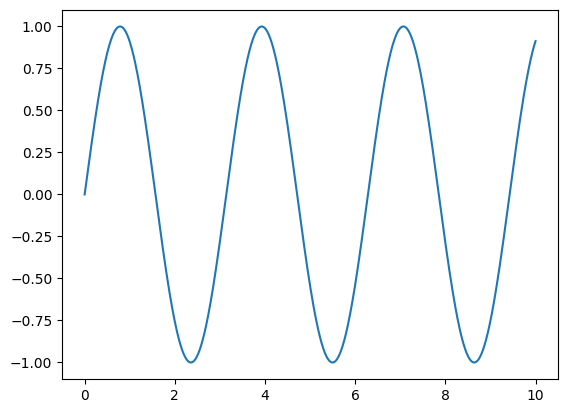

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

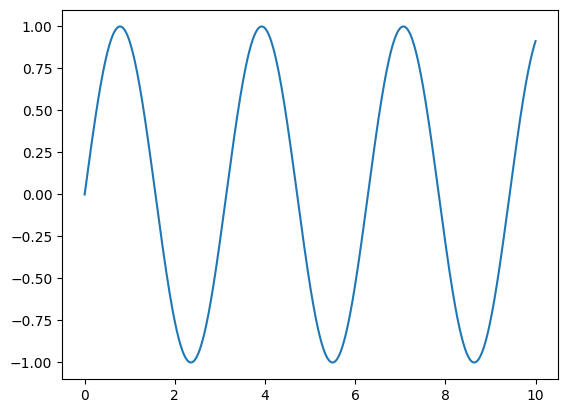

In [4]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

Using this alone can bring a nice performance boost on the GPU/TPU.

**Big difference: JAX arrays are immutable!**

In [5]:
x = np.arange(10)
x[0] = 10
x

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [6]:
x = jnp.arange(10)
x[0] = 10

TypeError: ignored

## Speed up computations with jit()
Just-in-time, or JIT compilation, is a method of executing code that lies between interpretation and ahead-of-time (AoT) compilation.

The important fact is that a JIT-compiler will compile code at runtime into a fast executable (at the cost of a slower first run).

In [7]:
def fn(x):
  return x + x*x + x*x*x

x_np = np.random.randn(5000, 5000).astype(dtype='float32')
%timeit -n5 fn(x_np)

x_jnp = jnp.array(x_np)
%timeit -n5 fn(x_jnp).block_until_ready()

jitted = jit(fn)
%timeit -n5 jitted(x_jnp).block_until_ready()

114 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 5.95 times longer than the fastest. This could mean that an intermediate result is being cached.
10 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 13.92 times longer than the fastest. This could mean that an intermediate result is being cached.
3.19 ms ± 5.04 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [8]:
# Use as decorator
@jit
def fn_jitted(x):
  return x + x*x + x*x*x

%timeit -n5 fn_jitted(x_jnp).block_until_ready()

The slowest run took 10.00 times longer than the fastest. This could mean that an intermediate result is being cached.
2.64 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## How does JIT works?

JIT and other JAX transforms work by tracing a function to determine its effect on inputs of a specific shape and type.

In [9]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)

In [10]:
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


Array([ 3.9272327, 12.678753 ,  8.021064 ], dtype=float32)

In [11]:
f(x, y)

Array([ 3.9272327, 12.678753 ,  8.021064 ], dtype=float32)

Notice that the print statements execute, but rather than printing the data we passed to the function, though, it prints tracer objects that stand-in for them.

These tracer objects are what jax.jit uses to extract the sequence of operations specified by the function. Basic tracers are stand-ins that encode the shape and dtype of the arrays, but are agnostic to the values. This recorded sequence of computations can then be efficiently applied within XLA to new inputs with the same shape and dtype, without having to re-execute the Python code.

When we call the compiled function again on matching inputs, no re-compilation is required and nothing is printed because the result is computed in compiled XLA rather than in Python.

## Limitation of JIT
**Important**: because JIT compilation is done without information on the content of the array, control flow statements in the function cannot depend on traced values.

In [12]:
# Important: because JIT compilation is done without information
# on the content of the array, control flow statements in the function cannot depend
# on traced values
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit = jit(f)
f_jit(10)  # Should raise an error.

TracerBoolConversionError: ignored

## Pure Functions
It needs [pure functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions):

- No control flow statements that depend on values
- It cannot use or change global state (variables outside its scope, global variables)
- It cannot have an I/O stream - so no printing, asking for input, or accessing the time
- It cannot have a mutable function as an argument (which a concurrent process could modify)

#### Untracked side effects!
Silently throw off the results of your calculation you should be sure that you understand how to write pure functions if you plan to utilize JAX. Read more [here](https://jax.readthedocs.io/en/latest/faq.html#jit-changes-the-behavior-of-my-function).

## Automatic Differentiation with grad()

Very simple to calculate gradients and second/third order gradients etc.

The gradients follow more the underlying math rather than using backpropagation in other Deep Learning libraries --> It can be much faster with JAX!

grad() works for scalar-valued function, meaning a function which maps scalars/vectors to scalars.

In [13]:
from jax import grad

def f(x):
  return x**3 + 2*x**2 - 3*x + 1

dfdx = grad(f)

d2fdx = grad(grad(f))
#d2fdx = grad(dfdx)

print(f"x = 1.0")
print(f"f  (x) = {f(1.)}")
print(f"f' (x) = 3*x^2 + 4x - 3 = {dfdx(1.)}")
print(f"f''(x) = 6x + 4 = {d2fdx(1.)}")

x = 1.0
f  (x) = 1.0
f' (x) = 3*x^2 + 4x - 3 = 4.0
f''(x) = 6x + 4 = 10.0


In [14]:
# Another example
def rectified_cube(x):
  r = 1

  if x < 0.:
    for i in range(3):
      r *= x
    r = -r
  else:
    for i in range(3):
        r *= x

  return r

gradient_function = grad(rectified_cube)

print(f"x = 2   f(x) = {rectified_cube(2.)}   f'(x) =  3*x^2 = {gradient_function(2.)}")
print(f"x = -3  f(x) = {rectified_cube(-3.)}  f'(x) = -3*x^2 = {gradient_function(-3.)}")

x = 2   f(x) = 8.0   f'(x) =  3*x^2 = 12.0
x = -3  f(x) = 27.0  f'(x) = -3*x^2 = -27.0


In [15]:
# use argnum
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = grad(sum_squared_error)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

sum_squared_error_dy = grad(sum_squared_error, argnums=(1))

print(sum_squared_error_dy(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]
[0.20000005 0.19999981 0.19999981 0.19999981]


## Jacobian and Hessian for Vector-Valued Functions
For vector-valued functions which map vectors to vectors, the analogue to the gradient is the Jacobian. With the function transformations jacfwd() and jacrev(), corresponding to forward mode differentiation and reverse mode differentiation.

In [16]:
from jax import jacfwd

def mapping(v):
  x = v[0]
  y = v[1]
  z = v[2]
  return jnp.array([x*x, y*z])

# 3 inputs, 2 outputs
# [d/dx x^2 , d/dy x^2, d/dz x^2]
# [d/dx y*z , d/dy y*z, d/dz y*z]

# [2*x , 0, 0]
# [0 , z, y]

f = jacfwd(mapping)
v = jnp.array([4., 5., 9.])
print(f(v))

[[8. 0. 0.]
 [0. 9. 5.]]


In [17]:
def hessian(f):
  return jacfwd(grad(f))

def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

## Automatic Vectorization with vmap()

JAX’s transform: Vectorization via vmap, the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of keeping the loop on the outside, it pushes the loop down into a function’s primitive operations for better performance.

In [18]:
from jax import vmap

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

print(convolve(x, w))

# Suppose we would like to apply this function to a batch of
# weights w to a batch of vectors x.
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

# use vmap instead of looping
auto_batch_convolve = vmap(convolve)

print(auto_batch_convolve(xs, ws))

[11. 20. 29.]
[[11. 20. 29.]
 [11. 20. 29.]]


## Automatic Parallelization with pmap()
Performing distributed training of SPMD programs with a single command

Consider the example of vector-matrix multiplication. Let’s say we are performing this computation by sequentially computing the dot product of the vector with each row of the matrix. We would need to push these computations through our hardware one at a time.

With JAX, we can easily distribute these computations across 4 TPUs by simply wrapping our operation in pmap(). This allows us to concurrently perform one dot product on each TPU, significantly increasing our computation speed (for large computations)

## Example Training Loop with JAX


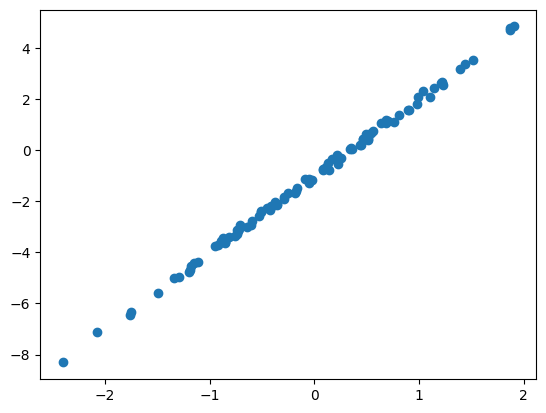

In [19]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [20]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.01
f(x) = 3.00 * x -1.01


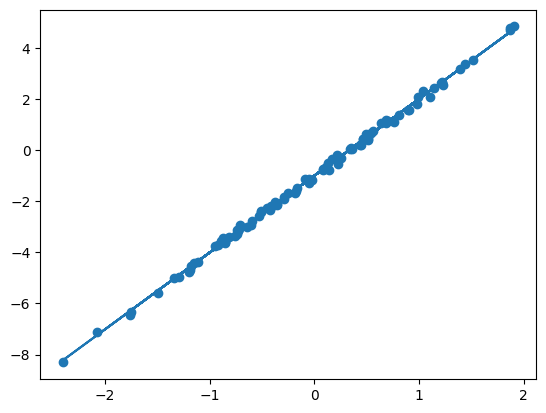

In [21]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")
print(f"f(x) = {w:<.2f} * x {b:<.2f}")

## What's the catch

- Functional Paradigm: Needs pure functions
- Untracked side effects
- Inability to modify arrays
- Explicit [PRNG handling](https://jax.readthedocs.io/en/latest/jax.random.html#prng-keys). Unlike the stateful pseudorandom number generators (PRNGs) that users of NumPy and SciPy may be accustomed to, JAX random functions all require an explicit PRNG state to be passed as a first argument. --> Be careful when you want to reproduce results.

## Conclusion

JAX is a very promising project and has been steadily growing in popularity, despite the learning curve introduced by its functional paradigm.

- Easy to use as drop-in replacement for numpy
- Autograd is extremelty useful for scientific computing
- Deep Learning projects can benefit from this!
- Huge performance improvement possible!!
- But be careful and make sure to understand pure functions and how jit works
- JAX is still officially considered an experimental framework.